In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np


In [3]:
dataset= pd.read_csv('/content/housing.csv')
dataset = dataset.dropna()
print("First 10 rows:")
dataset.head(10)
#dataset.shape[0]


First 10 rows:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [4]:
!pip install matplotlib

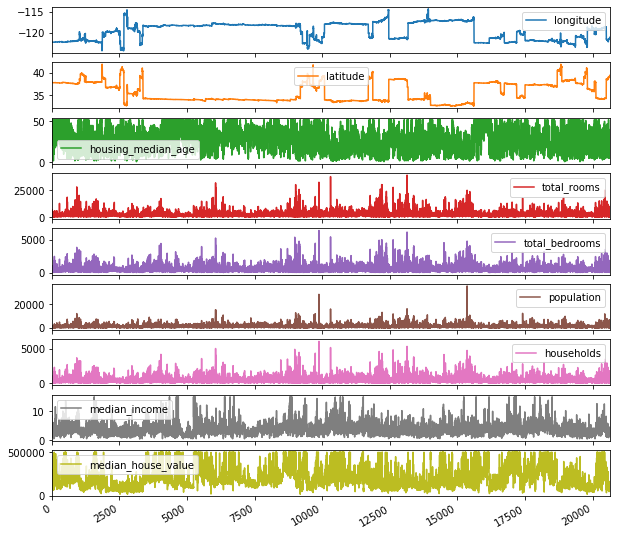

In [5]:
import matplotlib.pyplot as plt
dataset.plot(subplots=True, figsize=(10,10)); plt.legend(loc='best')



In [0]:
Y= dataset['median_house_value']
X= dataset.loc[:,'longitude':'median_income']

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()
x_test_np=x_test.to_numpy()
y_test_np=y_test.to_numpy()

In [9]:
!pip3 install Cython

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset


In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self,batch_size,inputs,outputs):
    super(CnnRegressor,self).__init__()
    self.batch_size=batch_size
    self.inputs=inputs
    self.outputs=outputs
    
    self.input_layer =Conv1d(inputs,batch_size,1)
    self.max_pooling_layer = MaxPool1d(1)
    self.conv_layer=Conv1d(batch_size,128,1)
    
    self.flatten_layer=Flatten()
    self.linear_layer=Linear(128,64)
    self.output_layer=Linear(64,outputs)


  def feed(self,input):
    input=input.reshape((self.batch_size,self.inputs,1))
    output=relu(self.input_layer(input))
    output=self.max_pooling_layer(output)
    output=relu(self.conv_layer(output))
    output=self.flatten_layer(output)
    output=self.linear_layer(output)
   
    output=self.output_layer(output)
    return output


In [12]:
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 34.6MB/s 


In [13]:
batch_size=64
model=CnnRegressor(batch_size,X.shape[1],1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric=R2Score()
  avg_loss=0
  avg_score=0
  count=0
  for input,output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)
    score_metric.update([predictions,output])
    score=score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_score += score
    count+=1
  return avg_loss/count , avg_score/count

In [16]:
epochs=200

optimizer = SGD(model.parameters(),lr=1e-5)
optimizer=Adam(model.parameters())
#optimizer = Adagrad(model.parameters())
inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np).reshape(y_train_np.shape[0],1).cuda().float()
tensor = TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

for epoch in range(epochs):
  avg_loss,avg_r2_score=model_loss(model,loader,train=True,optimizer=optimizer)

  print ("Epoch:" + str(epoch+1) + "\n\tLoss=" + str(avg_loss)+"\n\tR^2 Score= "+ str(avg_r2_score))

Epoch:1
	Loss=134762.02872757846
	R^2 Score= -2.086741614183403
Epoch:2
	Loss=100373.86792320627
	R^2 Score= -0.7005266416735129
Epoch:3
	Loss=82111.60331418162
	R^2 Score= 0.09034375093628731
Epoch:4
	Loss=80023.6271720852
	R^2 Score= 0.19520756295900774
Epoch:5
	Loss=78360.34702564462
	R^2 Score= 0.2083950403840863
Epoch:6
	Loss=77034.50115610987
	R^2 Score= 0.2407127130133407
Epoch:7
	Loss=75992.56652886771
	R^2 Score= 0.2762423026936454
Epoch:8
	Loss=74150.6197975056
	R^2 Score= 0.3046547696667936
Epoch:9
	Loss=71753.17248808856
	R^2 Score= 0.34742296062508254
Epoch:10
	Loss=69634.7668161435
	R^2 Score= 0.36497290070742666
Epoch:11
	Loss=67833.57630325112
	R^2 Score= 0.397155234468632
Epoch:12
	Loss=67099.10061659192
	R^2 Score= 0.396598541018598
Epoch:13
	Loss=65619.57849285314
	R^2 Score= 0.428552204685745
Epoch:14
	Loss=64566.75432665359
	R^2 Score= 0.4406479936084628
Epoch:15
	Loss=63472.42611406951
	R^2 Score= 0.4663556803356089
Epoch:16
	Loss=62737.73577634529
	R^2 Score= 0.4

In [17]:
inputs=torch.from_numpy(x_test_np).cuda().float()
outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)
avg_loss, avg_r2_score= model_loss(model,loader)
print("L1_Loss:" + str(avg_loss))
print("R^2 score:" + str(avg_r2_score))

L1_Loss:47486.32537006579
R^2 score:0.6714859566009553


In [18]:
torch.save(model,'1110790_1dconv_reg.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
